In [ ]:
# 30个频率频道 116*116输入   3种不同3dcnn模型的对比  

In [ ]:
# !pip install import-ipynb
# import import_ipynb

%tensorflow_version 1.x

TensorFlow 1.x selected.


In [1]:

import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt 
from keras.models import Model, Sequential 
from keras.layers import Conv1D,Flatten,Conv2D, Dropout, MaxPooling2D, LSTM
from keras.layers import Input,Conv3D, MaxPooling3D, Dense, BatchNormalization,MaxPooling1D,MaxPool1D
from keras.layers.merge import concatenate 
from keras.layers import Flatten 
from google.colab import drive
from keras.layers import Conv2D
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier,KerasRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
drive.mount('/content/drive')
# %cp -av fromfolder tofolder
# %cd "/content/drive/My Drive/Newdata/"
# from model_functions import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def extract_half_of_matrix1(patient):# 把原始的matrix数据延对角线 只保留一半的数据
  
  result = []
  for m in range(150):
    Herz=[]
    for i in range (30):
      half_matrix = []
      for j in range(116):
          for k in range(j,116):
              half_matrix.append(patient[m,i,j,k])
      Herz.append(half_matrix)
    result.append(Herz) 
  Herz = np.array(result)

  return Herz 


In [3]:
# 116*116保留一半 
data = []
label2 = []
label3 = []
for i in range(1,25):
  a = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_keep30_150_' + str(i) +'.npy')
  a = a.reshape((150,30,116,116))
  b = extract_half_of_matrix1(a)
  c = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/two_labels/' + str(i) + '.npy')  #两个label
  d = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/percent_output_' + str(i) + '.npy')  #三个label
  data.append(b)
  label2.append(c)
  label3.append(d)

# print(data[0].shape)
# print(label2[0].shape)
# print(label3[0].shape)

# (150, 30, 6786)
# (150, 2)
# (150, 3)

In [4]:
# 按照病人打乱顺序
Data, Label2, Label3 = shuffle(data, label2, label3, random_state = 20)

# 将shuffle后的数据的前20个病人数据做训练+验证集
train_val_data = Data[:20]
train_val_label2 = Label2[:20] 
train_val_label3 = Label3[:20] 

train_data = train_val_data[:16]
val_data = train_val_data[16:]

train_label2 = train_val_label2[:16]
val_label2 = train_val_label2[16:]

train_label3 = train_val_label3[:16]
val_label3 = train_val_label3[16:]


# 将shuffle后的数据的后4个病人数据做测试集
test_data = Data[20:]
test_label2 = Label2[20:]
test_label3 = Label3[20:]

train_data = np.array(train_data)
train_data = np.reshape(train_data,(2400,6786,30))

val_data = np.array(val_data)
val_data = np.reshape(val_data,(600,6786,30))

train_label2 = np.array(train_label2)
train_label2 = np.reshape(train_label2,(2400,2))

val_label2 = np.array(val_label2)
val_label2 = np.reshape(val_label2,(600,2))

train_label3 = np.array(train_label3)
train_label3 = np.reshape(train_label3,(2400,3))

val_label3 = np.array(val_label3)
val_label3 = np.reshape(val_label3,(600,3))


test_data = np.array(test_data)
test_data = np.reshape(test_data,(600,6786,30))

test_label2 = np.array(test_label2)
test_label2 = np.reshape(test_label2,(600,2))

test_label3 = np.array(test_label3)
test_label3 = np.reshape(test_label3,(600,3))


In [5]:
train_data, train_label = shuffle(train_data, train_label3, random_state = 20)

In [5]:
#数据合到一起
P = np.array(Data)
P = np.reshape(P,(3600,6786,30))

L2 = np.array(Label2)
L2 = np.reshape(L2,(3600,2))

L3 = np.array(Label3)
L3 = np.reshape(L3,(3600,3))
print(P.shape)
print(L2.shape)
print(L3.shape)


(3600, 6786, 30)
(3600, 2)
(3600, 3)


In [ ]:
#不按照病人 全部打乱 
P, L2, L3 = shuffle(P, L2, L3, random_state = 20)


In [6]:
#输入数据
train_data = P[:3000]  
test_data = P[3000:]

In [ ]:
# 2 label
train_label  = L2[:3000]
test_label = L2[3000:]

print(train_data.shape)
print(train_label.shape)


# 3 label
train_label  = L3[:3000]
test_label = L3[3000:]

print(train_data.shape)
print(train_label.shape)

(2700, 116, 116, 3)
(2700, 2)


In [8]:
train_data, train_label = shuffle(train_data, train_label, random_state = 20)

In [9]:
# count = 0
# for i in range(24):
#   for j in range(150):
#     # if Label3[i,j,0] + Label3[i,j,1] + Label3[i,j,2]  == 1:
#     if L3[i,j,0] + L3[i,j,1] + L3[i,j,2]  == 1:
#       count+=1
# print(count)

count = 0
for i in range(3600):
    if L3[i,0] + L3[i,1] + L3[i,2]  == 1:
      count+=1
print(count)

# print(L3)

3600


In [ ]:

k = 5
num_val_samples = len(data)//k
# for i in range(k):
i = 2
print('processing fold #', i)
test_data = data[i * num_val_samples: (i + 1) * num_val_samples]
test_label = label[i * num_val_samples: (i + 1) * num_val_samples]
train_data = np.concatenate([data[:i * num_val_samples],data[(i + 1) * num_val_samples:]], axis=0)
train_label = np.concatenate([label[:i * num_val_samples],label[(i + 1) * num_val_samples:]], axis=0)

processing fold # 2


In [6]:
def Model():
  model = Sequential()
  initializer = tf.keras.initializers.he_uniform(seed = 0)
  model.add(Conv1D(30, activation='relu',kernel_size=10, input_shape=(6786, 30), kernel_initializer=initializer))
  model.add(BatchNormalization())
  # model.add(MaxPool1D(pool_size=2)
  # model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=50, kernel_initializer=initializer))
  model.add(BatchNormalization())
  # model.add(LSTM(4))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(30,activation='relu', kernel_size=5, kernel_initializer=initializer))
  model.add(MaxPooling1D(pool_size=2))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=5, kernel_initializer=initializer))
  model.add(MaxPooling1D(pool_size=2))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=5, kernel_initializer=initializer))
  model.add(MaxPooling1D(pool_size=2))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=5, kernel_initializer=initializer))
  model.add(MaxPooling1D(pool_size=2))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=5, kernel_initializer=initializer))
  model.add(MaxPooling1D(pool_size=2))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=5, kernel_initializer=initializer))
  model.add(MaxPooling1D(pool_size=2))
  model.add(BatchNormalization())
  model.add(Conv1D(30,activation='relu', kernel_size=3, kernel_initializer=initializer))
  model.add(MaxPooling1D(pool_size=2))
  model.add(BatchNormalization())
  # model.add(Conv1D(30,activation='relu', kernel_size=5))
  # model.add(MaxPooling1D(pool_size=2))
  # model.add(Conv1D(30,activation='relu', kernel_size=5))
  # model.add(MaxPooling1D(pool_size=2))
  # model.add(Conv1D(30,activation='relu', kernel_size=5))
  # model.add(MaxPooling1D(pool_size=2))
  # model.add(BatchNormalization())
  model.add(Flatten())
  # model.add(Dropout(0.4))
  model.add(Dense(2048, activation='relu'))
  model.add(Dense(1024, activation='relu'))
  # model.add(Dense(3,activation='sigmoid'))
  model.add(Dense(3))

  
  model.summary()
  from keras.optimizers import RMSprop,Adam,SGD,Adagrad
  model.compile(optimizer =  RMSprop(learning_rate=0.00001, momentum=0.9),
                loss = 'mean_squared_error',
                metrics = ['mae'])
  return model




In [7]:
num_epochs = 150
batchsize = 64
model = Model()
history = model.fit(train_data, train_label, epochs=num_epochs, batch_size=batchsize, verbose=1,validation_data=(val_data, val_label3))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 6777, 30)          9030      
_________________________________________________________________
batch_normalization (BatchNo (None, 6777, 30)          120       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6728, 30)          45030     
_________________________________________________________________
batch_normalization_1 (Batch (None, 6728, 30)          120       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6679, 30)          45030     
_________________________________________________________________
batch_normalization_2 (Batch (None, 6679, 30)          120       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6630, 30)          4

# 全部混合

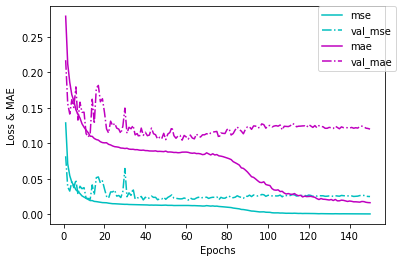

In [10]:
# 这是按照病人来的
mse_history = history.history['loss']
mae_history = history.history['mae']
valmse_history = history.history['val_loss']
valmae_history = history.history['val_mae']

epochs = range(1,len(mse_history) +1)
plt.plot(epochs, mse_history, 'c', label='mse')
plt.plot(epochs, valmse_history, 'c-.', label='val_mse')

plt.plot(epochs, mae_history, 'm', label='mae')
plt.plot(epochs, valmae_history, 'm-.', label='val_mae')

plt.legend(bbox_to_anchor=(0.8, 1), loc='upper left', borderaxespad=0.)

plt.xlabel('Epochs')
plt.ylabel('Loss & MAE')

plt.savefig('/content/drive/My Drive/images/1dcnn/loss_mae.png' ,dpi=800)

array([-1.34910809, -1.03856465, -8.36171349])

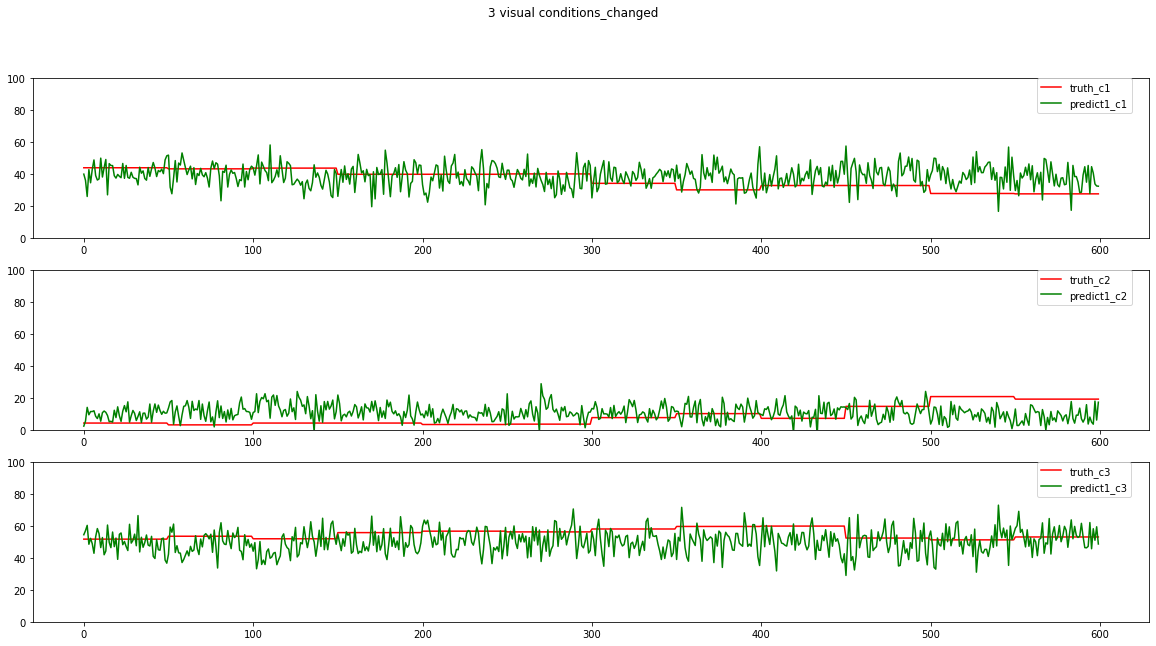

In [13]:
# 这是按照病人来的
comparision1 = (model.predict(test_data))*100
Test_label = test_label3*100
x_data = range(600)
y_data_c1 = Test_label[:,0]
y_data_c2 = Test_label[:,1]
y_data_c3 = Test_label[:,2]
y_predict1_c1 = comparision1[:,0]
y_predict1_c2 = comparision1[:,1]
y_predict1_c3 = comparision1[:,2]

fig, (predict_c1, predict_c2, predict_c3) = plt.subplots(3,figsize=(20,10))
fig.suptitle('3 visual conditions_changed') 

# axes = plt.gca()
# axes.set_xlim([xmin,xmax])
# axes.set_ylim([0,1])

predict_c1.set_ylim([0,100])
predict_c2.set_ylim([0,100])
predict_c3.set_ylim([0,100])
predict_c1.plot(x_data, y_data_c1 , 'r', label='truth_c1')
predict_c2.plot(x_data, y_data_c2 , 'r', label='truth_c2')
predict_c3.plot(x_data, y_data_c3 , 'r', label='truth_c3')
predict_c1.plot(x_data, y_predict1_c1 , 'g', label='predict1_c1')
predict_c2.plot(x_data, y_predict1_c2 , 'g', label='predict1_c2')
predict_c3.plot(x_data, y_predict1_c3 , 'g', label='predict1_c3')
predict_c1.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c3.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)

plt.savefig('/content/drive/My Drive/images/1dcnn/test.png' ,dpi=800)

r2_score(Test_label, comparision1, multioutput='raw_values')

# 按照病人来 

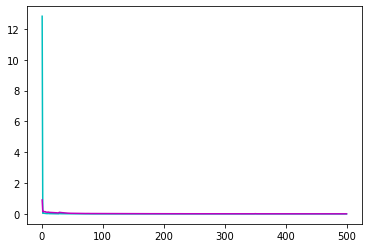

In [ ]:
# 这是按照病人来的
mse_history = history.history['loss']
mae_history = history.history['mae']

epochs = range(1,len(mse_history) +1)
plt.plot(epochs, mse_history, 'c', label='mse')
plt.plot(epochs, mae_history, 'm', label='mae')

# plt.savefig('/content/drive/My Drive/train18_test6_50epo_mse_mae1.png' ,dpi=1200)

array([-0.03411238, -0.2271912 , -1.48371741])

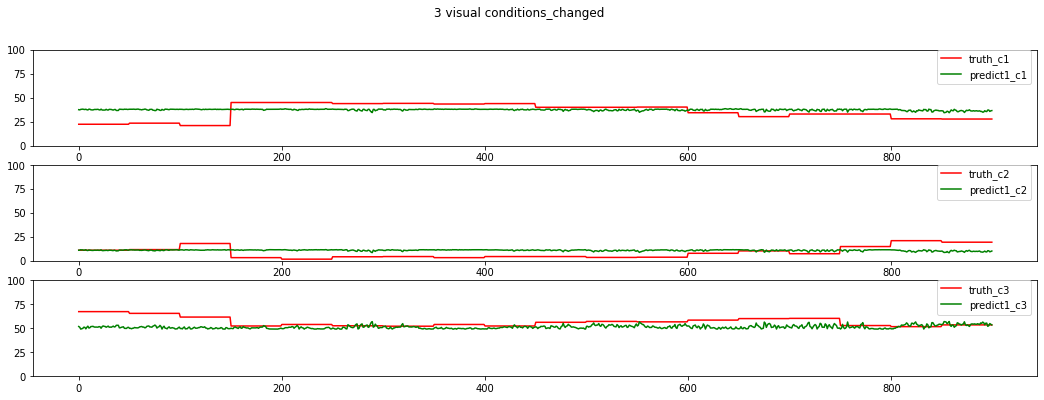

In [ ]:
#测试集
comparision1 = (model.predict(test_data))*100
Test_label = test_label*100
x_data = range(900)
y_data_c1 = Test_label[:,0]
y_data_c2 = Test_label[:,1]
y_data_c3 = Test_label[:,2]
y_predict1_c1 = comparision1[:,0]
y_predict1_c2 = comparision1[:,1]
y_predict1_c3 = comparision1[:,2]

fig, (predict_c1, predict_c2, predict_c3) = plt.subplots(3,figsize=(18,6))
fig.suptitle('3 visual conditions_changed') 

predict_c1.set_ylim([0,100])
predict_c2.set_ylim([0,100])
predict_c3.set_ylim([0,100])
predict_c1.plot(x_data, y_data_c1 , 'r', label='truth_c1')
predict_c2.plot(x_data, y_data_c2 , 'r', label='truth_c2')
predict_c3.plot(x_data, y_data_c3 , 'r', label='truth_c3')
predict_c1.plot(x_data, y_predict1_c1 , 'g', label='predict1_c1')
predict_c2.plot(x_data, y_predict1_c2 , 'g', label='predict1_c2')
predict_c3.plot(x_data, y_predict1_c3 , 'g', label='predict1_c3')
predict_c1.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c3.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)

# plt.savefig('/content/drive/My Drive/train18_test6_50epo_comparison1.png' ,dpi=1200)

r2_score(Test_label, comparision1, multioutput='raw_values')

# 训练集

array([0.97564608, 0.9633503 , 0.96983382])

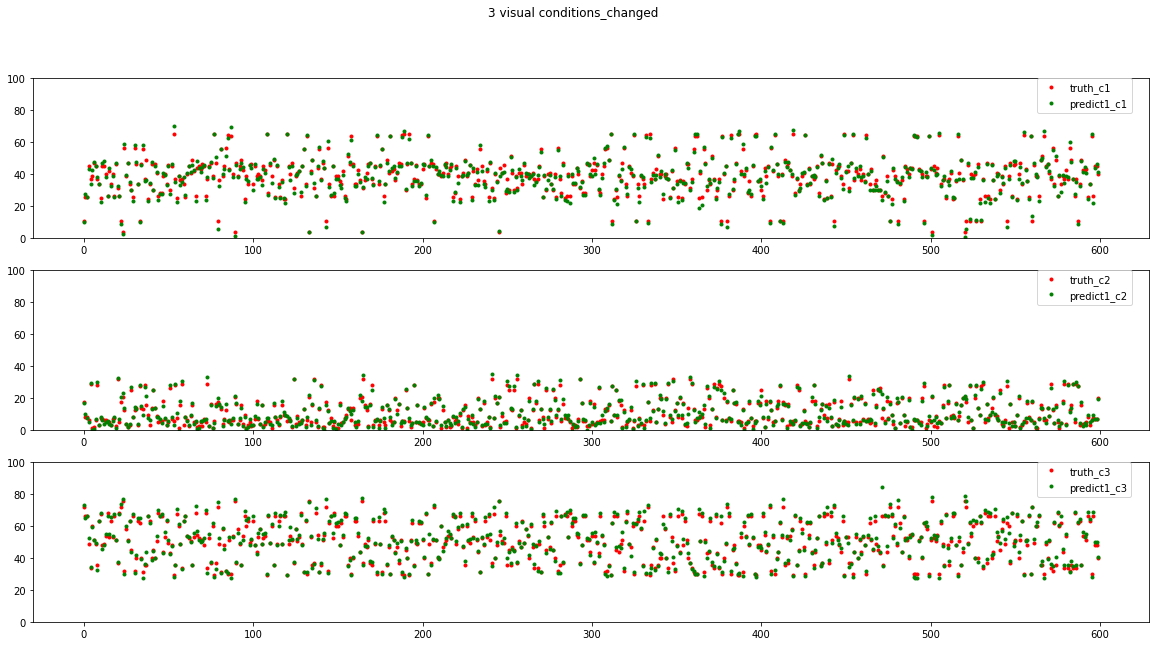

In [22]:
#训练集
comparision1 = (model.predict(train_data))*100
Test_label = train_label*100
x_data = range(600)
set_num = 600
y_data_c1 = Test_label[:,0]
y_data_c2 = Test_label[:,1]
y_data_c3 = Test_label[:,2]
y_predict1_c1 = comparision1[:,0]
y_predict1_c2 = comparision1[:,1]
y_predict1_c3 = comparision1[:,2]

fig, (predict_c1, predict_c2, predict_c3) = plt.subplots(3,figsize=(20,10))
fig.suptitle('3 visual conditions_changed') 

predict_c1.set_ylim([0,100])
predict_c2.set_ylim([0,100])
predict_c3.set_ylim([0,100])

predict_c1.plot(x_data, y_data_c1[:set_num] , 'r.', label='truth_c1')
predict_c2.plot(x_data, y_data_c2[:set_num] , 'r.', label='truth_c2')
predict_c3.plot(x_data, y_data_c3[:set_num] , 'r.', label='truth_c3')
predict_c1.plot(x_data, y_predict1_c1[:set_num] , 'g.', label='predict1_c1')
predict_c2.plot(x_data, y_predict1_c2[:set_num] , 'g.', label='predict1_c2')
predict_c3.plot(x_data, y_predict1_c3[:set_num] , 'g.', label='predict1_c3')
predict_c1.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c3.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)

plt.savefig('/content/drive/My Drive/images/1dcnn/train.png' ,dpi=800)

r2_score(Test_label, comparision1, multioutput='raw_values')

# 不许动

array([0.98683376, 0.99587982, 0.97265373])

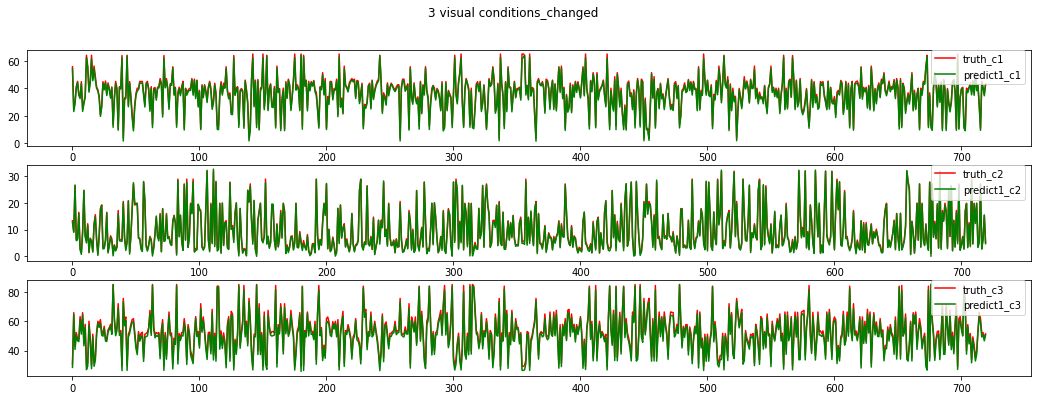

In [ ]:

comparision1 = (model.predict(test_data))*100
Test_label = test_label*100
x_data = range(720)
y_data_c1 = Test_label[:,0]
y_data_c2 = Test_label[:,1]
y_data_c3 = Test_label[:,2]
y_predict1_c1 = comparision1[:,0]
y_predict1_c2 = comparision1[:,1]
y_predict1_c3 = comparision1[:,2]

fig, (predict_c1, predict_c2, predict_c3) = plt.subplots(3,figsize=(18,6))
fig.suptitle('3 visual conditions_changed') 

predict_c1.plot(x_data, y_data_c1 , 'r', label='truth_c1')
predict_c2.plot(x_data, y_data_c2 , 'r', label='truth_c2')
predict_c3.plot(x_data, y_data_c3 , 'r', label='truth_c3')
predict_c1.plot(x_data, y_predict1_c1 , 'g', label='predict1_c1')
predict_c2.plot(x_data, y_predict1_c2 , 'g', label='predict1_c2')
predict_c3.plot(x_data, y_predict1_c3 , 'g', label='predict1_c3')
predict_c1.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)
predict_c3.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0.)

# plt.savefig('/content/drive/My Drive/train18_test6_50epo_comparison1.png' ,dpi=1200)

r2_score(Test_label, comparision1, multioutput='raw_values')

In [ ]:
# data = np.load('/content/drive/My Drive/Newdata/shuffle_changedin4800.npy')
label = np.load('/content/drive/My Drive/Newdata/shuffle_changedout4800.npy')
data = np.reshape(data,(4800,30,116,116,1))
split_rate= 0.7
split = int(split_rate*4800)
train_data = data[:split]
train_label = label[:split]
test_data = data[split:]
test_label = label[split:] 


def k_fold(k,train_data,train_targets):
  num_val_samples = len(train_data)//k
  val_mses = []
  val_maes = []
  mse_History = []
  mae_History = []
  num_epochs = 50
  batchsize = 6
  R2 = []
  Comparision = []
  for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]], axis=0)
    model = Model()
    history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=batchsize, verbose=0)
    comparision1 = (model.predict(test_data))*100
    Test_label = test_label*100
    Comparision.append(comparision1)
    # r2_score(Test_label, comparision1, multioutput='raw_values')
    R2.append(r2_score(Test_label, comparision1, multioutput='raw_values'))
    # val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    # mse_history = history.history['loss']
    # mae_history = history.history['mean_absolute_error']
    # val_mses.append(val_mse)
    # val_maes.append(val_mae)
    # mse_History.append(mse_history)
    # mae_History.append(mae_history)
  # return val_mses, val_maes, mse_History, mae_History
  return  R2,Comparision

R2_score, Predict_results = k_fold(5,train_data,train_label)


# average_mae_history = [(np.mean([x[i] for x in mae_history]))*100 for i in range(50)] 
# average_mse_history = [(np.mean([x[i] for x in mse_history]))*100 for i in range(50)] 
# #model 3Dcnn 
# epochs = range(1,len(average_mse_history)+1)
# plt.plot(epochs, average_mae_history,'c',  label='mae' )
# plt.plot(epochs, average_mse_history,'m',  label='mse' )
# plt.xlabel('Epochs')
# plt.ylabel('Validation')
# plt.show()


In [ ]:
mse_history = history.history['loss']
mae_history = history.history['mean_absolute_error'] 
comparision1 = (model.predict(test_data[:100]))*100
x_data = range(1080)
Test_label = test_label[:100]*100
y_data_c1 = Test_label[:,0]
y_data_c2 = Test_label[:,1]
y_data_c3 = Test_label[:,2]
y_predict1_c1 = comparision1[:,0]
y_predict1_c2 = comparision1[:,1]
y_predict1_c3 = comparision1[:,2]

fig, (predict_c1, predict_c2, predict_c3) = plt.subplots(3)
fig.suptitle('3 visual conditions') 
plt.subplots(figsize=(50, 10))
# fig, ax = plt.subplots(figsize=(20, 10))

predict_c1.plot(x_data, y_data_c1 , 'r', label='truth_c1')
predict_c2.plot(x_data, y_data_c2 , 'r', label='truth_c2')
predict_c3.plot(x_data, y_data_c3 , 'r', label='truth_c3')
predict_c1.plot(x_data, y_predict1_c1 , 'b', label='predict1_c1')
predict_c2.plot(x_data, y_predict1_c2 , 'b', label='predict1_c2')
predict_c3.plot(x_data, y_predict1_c3 , 'b', label='predict1_c3')
from sklearn.metrics import r2_score
r2_score(Test_label, comparision1, multioutput='raw_values')

In [ ]:
# !cat ~/.keras/keras.json

# from keras import backend
# backend.set_image_data_format('channels_first')
# print(backend.image_data_format())

# !cat ~/.keras/keras.json

In [ ]:
# # print(open("~/.keras/keras.json").read())
# content = {"epsilon": 1e-07, 
#     "floatx": "float32", 
#     "image_data_format": "channels_first", 
#     "backend": "tensorflow"}
# with open(" ~/.keras/keras.json",'w') as f:
#   f.write(str(content))
# # print(open("~/.keras/keras.json").read())


In [ ]:

# tmp = data2[3,0,:,:]
# # np.set_printoptions(threshold=np.inf)  #打印全部内容 没有缩写
# print(tmp.shape)
# # print(tmp[:,:])
# tmp=tmp.astype(np.float) # conver to float  and plot 
# # %matplotlib qt 
# %matplotlib inline
# plt.imshow(tmp,cmap='GnBu')
# plt.savefig('/content/drive/My Drive/input_example.png' ,dpi=2400)


In [ ]:
# aaa = np.load('/content/drive/My Drive/output/M2.npy')
# ppp = aaa[0]
# print(ppp.shape)
# ppp=ppp.astype(np.float) # conver to float  and plot 
# # %matplotlib qt 
# %matplotlib inline
# plt.imshow(ppp,cmap='gray')
# plt.savefig('/content/drive/My Drive/output_example.png' ,dpi=2400)

In [ ]:
def SPLIT(data,split):

  data, label = shuffle(data, Label, random_state=20)

  train_data = data[:split]
  train_label = label[:split]
  test_data = data[split:]
  test_label = label[split:]

  return train_data, train_label, test_data, test_label


train_data, train_label, test_data, test_label = SPLIT(data,72)
# train_data1, train_label1, test_data1, test_label1 = SPLIT(data1,72)
# train_data2, train_label2, test_data2, test_label2 = SPLIT(data2,72)

In [ ]:
def k_fold(k,train_data,train_targets):
  num_val_samples = len(train_data)//k
  val_mses = []
  val_maes = []
  mse_History = []
  mae_History = []
  num_epochs = 100
  batchsize = 6
  for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]], axis=0)
    model = threeD_CNN()
    history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=batchsize, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    mse_history = history.history['loss']
    mae_history = history.history['mean_absolute_error']
    val_mses.append(val_mse)
    val_maes.append(val_mae)
    mse_History.append(mse_history)
    mae_History.append(mae_history)
  return val_mses, val_maes, mse_History, mae_History

val_mses, val_maes, mse_history, mae_history = k_fold(4,train_data,train_label)


average_mae_history = [(np.mean([x[i] for x in mae_history]))*100 for i in range(100)] 
average_mse_history = [(np.mean([x[i] for x in mse_history]))*100 for i in range(100)] 
#model 3Dcnn 
epochs = range(1,len(average_mse_history)+1)
plt.plot(epochs, average_mae_history,'c',  label='mae' )
plt.plot(epochs, average_mse_history,'m',  label='mse' )
plt.xlabel('Epochs')
plt.ylabel('Validation')
plt.show()


In [ ]:
def k_fold(k,train_data,train_targets):
  num_val_samples = len(train_data)//k
  val_mses = []
  val_maes = []
  mse_History = []
  mae_History = []
  num_epochs = 100
  batchsize = 6
  for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]], axis=0)
    model = threeD_CNN1()
    history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=batchsize, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    mse_history = history.history['loss']
    mae_history = history.history['mean_absolute_error']
    val_mses.append(val_mse)
    val_maes.append(val_mae)
    mse_History.append(mse_history)
    mae_History.append(mae_history)
  return val_mses, val_maes, mse_History, mae_History

val_mses1, val_maes1, mse_history1, mae_history1 = k_fold(4,train_data,train_label) 

average_mae_history1 = [(np.mean([x[i] for x in mae_history1]))*100 for i in range(100)] 
average_mse_history1= [(np.mean([x[i] for x in mse_history1]))*100 for i in range(100)] 
#model 3Dcnn 
epochs = range(1,len(average_mse_history1)+1)
plt.plot(epochs, average_mae_history1,'c',  label='mae' )
plt.plot(epochs, average_mse_history1,'m',  label='mse' )
plt.xlabel('Epochs')
plt.ylabel('Validation')
plt.show()
# batchsize = 6
# model1 = threeD_CNN()
# history1 = model1.fit(train_data, train_label, epochs = 100, batch_size = batchsize, verbose=0)
# model2 = threeD_CNN1()
# history2 = model2.fit(train_data, train_label, epochs = 100, batch_size = batchsize,verbose=0)
# model3 = threeD_CNN2()
# history3 = model3.fit(train_data, train_label, epochs = 100,batch_size = batchsize, verbose=0)


In [ ]:
def k_fold(k,train_data,train_targets):
  num_val_samples = len(train_data)//k
  val_mses = []
  val_maes = []
  mse_History = []
  mae_History = []
  num_epochs = 100
  batchsize = 6
  for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]], axis=0)
    model = threeD_CNN2()
    history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=batchsize, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    mse_history = history.history['loss']
    mae_history = history.history['mean_absolute_error']
    val_mses.append(val_mse)
    val_maes.append(val_mae)
    mse_History.append(mse_history)
    mae_History.append(mae_history)
  return val_mses, val_maes, mse_History, mae_History

val_mses2, val_maes2, mse_history2, mae_history2 = k_fold(4,train_data,train_label) 

average_mae_history2 = [(np.mean([x[i] for x in mae_history2]))*100 for i in range(100)] 
average_mse_history2 = [(np.mean([x[i] for x in mse_history2]))*100 for i in range(100)] 
#model 3Dcnn 
epochs = range(1,len(average_mse_history2)+1)
plt.plot(epochs, average_mae_history2,'c',  label='mae' )
plt.plot(epochs, average_mse_history2,'m',  label='mse' )
plt.xlabel('Epochs')
plt.ylabel('Validation')
plt.show()
# batchsize = 6
# model1 = threeD_CNN()
# history1 = model1.fit(train_data, train_label, epochs = 100, batch_size = batchsize, verbose=0)
# model2 = threeD_CNN1()
# history2 = model2.fit(train_data, train_label, epochs = 100, batch_size = batchsize,verbose=0)
# model3 = threeD_CNN2()
# history3 = model3.fit(train_data, train_label, epochs = 100,batch_size = batchsize, verbose=0)


In [ ]:
epochs = range(1,len(average_mse_history)+1)
plt.plot(epochs, average_mae_history,'c',  label='mae' )
plt.plot(epochs, average_mse_history,'c--',  label='mse' )
plt.plot(epochs, average_mae_history1,'m',  label='mae1' )
plt.plot(epochs, average_mse_history1,'m--',  label='mse1' )
plt.plot(epochs, average_mae_history2,'r',  label='mae2' )
plt.plot(epochs, average_mse_history2,'r--',  label='mse2' )
plt.xlabel('Epochs')
plt.ylabel('Average_performance')
plt.legend()
# plt.show()
plt.savefig('/content/drive/My Drive/original_30_3models_comparison.png' ,dpi=1200)

In [ ]:
mse1 = history1.history['loss']
mae1 = history1.history['mean_absolute_error']
mse2 = history2.history['loss']
mae2 = history2.history['mean_absolute_error']
mse3 = history3.history['loss']
mae3 = history3.history['mean_absolute_error']
# val_loss = history.history['val_loss']
# acc = history.history['acc']
# val_acc=history.history['val_acc']
epochs = range(1,len(mse1) +1)
plt.plot(epochs, mse1, 'c', label='mse1')
plt.plot(epochs, mse2, 'm', label='mse2')
plt.plot(epochs, mse3, 'r', label='mse3')

plt.plot(epochs, mae1, 'c--', label='mae1')
plt.plot(epochs, mae2, 'm--', label='mae2')
plt.plot(epochs, mae3, 'r--', label='mae3')

plt.title('loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show() 
# plt.savefig('/content/drive/My Drive/original_30_3models_comparison.png' ,dpi=2400)

In [ ]:
comparision1 = (model1.predict(test_data))*100
comparision2 =(model2.predict(test_data))*100
comparision3 = (model3.predict(test_data))*100
print(comparision1[0,0])
print(comparision2)


In [ ]:
x_data = range(24)
Test_label = test_label*100
y_data_c1 = Test_label[:,0]
y_data_c2 = Test_label[:,1]
y_data_c3 = Test_label[:,2]
y_predict1_c1 = comparision1[:,0]
y_predict1_c2 = comparision1[:,1]
y_predict1_c3 = comparision1[:,2]
y_predict2_c1 = comparision2[:,0]
y_predict2_c2 = comparision2[:,1]
y_predict2_c3 = comparision2[:,2]
y_predict3_c1 = comparision3[:,0]
y_predict3_c2 = comparision3[:,1]
y_predict3_c3 = comparision3[:,2]

fig, (predict_c1, predict_c2, predict_c3) = plt.subplots(3)
fig.suptitle('3 visual conditions') 


predict_c1.plot(x_data, y_data_c1 , 'c', label='truth_c1')
predict_c2.plot(x_data, y_data_c2 , 'r', label='truth_c2')
predict_c3.plot(x_data, y_data_c3 , 'b', label='truth_c3')
predict_c1.plot(x_data, y_predict1_c1 , 'c--', label='predict1_c1')
predict_c2.plot(x_data, y_predict1_c2 , 'r--', label='predict1_c2')
predict_c3.plot(x_data, y_predict1_c3 , 'b--', label='predict1_c3')
predict_c1.plot(x_data, y_predict2_c1 , 'c:', label='predict2_c1')
predict_c2.plot(x_data, y_predict2_c2 , 'r:', label='predict2_c2')
predict_c3.plot(x_data, y_predict2_c3 , 'b:', label='predict2_c3')
predict_c1.plot(x_data, y_predict3_c1 , 'c-.', label='predict2_c1')
predict_c2.plot(x_data, y_predict3_c2 , 'r-.', label='predict2_c2')
predict_c3.plot(x_data, y_predict3_c3 , 'b-.', label='predict2_c3')

predict_c1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
predict_c2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
predict_c3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# plt.title('loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.show() 
# fig.savefig('/content/drive/My Drive/ready_data_6C/matrix_input/1.png' ,bbox_inches='tight')

In [ ]:
print(comparision1.shape)
y_data_c1 = test_label[:,0]
print(y_data_c1.shape)

In [ ]:
def calculate_mse(predict):   #对比三种视觉情况 每个model的mse  
  y_data_c1 = test_label[:,0]
  y_data_c2 = test_label[:,1]
  y_data_c3 = test_label[:,2]
  y_predict1_c1 = predict[:,0]
  y_predict1_c2 = predict[:,1]
  y_predict1_c3 = predict[:,2]
  tmp1 = 0
  tmp2 = 0
  tmp3 = 0
  for i in range(24):
    tmp1 = tmp1 + (y_data_c1[i]- y_predict1_c1[i])**2
    tmp2 = tmp2 + (y_data_c2[i]- y_predict1_c2[i])**2
    tmp3 = tmp3 + (y_data_c3[i]- y_predict1_c3[i])**2
  c1 = tmp1 /24 
  c2 = tmp2 /24
  c3 = tmp3 /24
  # c1 = K.mean(K.square( y_data_c1- y_predict1_c1), axis=-1)
  # c2 = K.mean(K.square( y_data_c2- y_predict1_c2), axis=-1)
  # c3 = K.mean(K.square( y_data_c3- y_predict1_c3), axis=-1)
  return c1 , c2 ,c3 


In [ ]:
# from keras import backend as K
Model1 = calculate_mse(comparision1)
Model2 = calculate_mse(comparision2)

In [ ]:
print(Model1)
print(Model2)